In [1]:
# IMPORT KNJIŽNICA I ARHITEKTURA MODELA
# Knjižice za procesiranje i formatiranje skupa podataka
from sklearn.preprocessing import MinMaxScaler
from seqprops import SequentialPropertiesEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tools import one_hot_encode_list, one_hot_decode_list, one_hot_decode, softmax_beta

# Knjižice za izgradnju VAE modela
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, LSTM, Bidirectional, Conv1D, Dropout, RepeatVector, TimeDistributed, Lambda, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K

# Knjižice za klasično korištenje
import os
import random
import pandas as pd
import numpy as np
from pylab import rcParams
import importlib
import importlib.resources

# Knjižice za grafove i crtanja
import seaborn as sns
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard, Callback

# Knjižica za testiranje validnosti novih dobivenih peptida
from seqprops_therapeutic import models

In [2]:
file = 'amp.csv'
df = pd.read_csv(file)

peptides = df.loc[:, 'sequence'].values
peptides_type = df.loc[:, 'label'].values
print(peptides)
print(peptides_type)

# Odredivanje dužine najduljeg peptida
max_peptide_len = 0
for peptide in peptides:
    max_peptide_len = max(len(peptide), max_peptide_len)
print("Duzina najdulje sekvence peptida: ", max_peptide_len)

['GEP' 'QHP' 'YLRF' ...
 'MGSPEKLRPSDFSKSFLISSIRFAMSFSSFELYSACSSLIRVSSPTMAET'
 'MLLPATMSDKPDMAEIEKFDKSKLKKTETQEKNPLPSKETIEQEKQAGES'
 'GATIKKCVVDVKLSKPCTFQECQPLCLQKYNGNGLCPGDDNNICACVYNC']
[0 0 0 ... 0 0 1]
Duzina najdulje sekvence peptida:  50


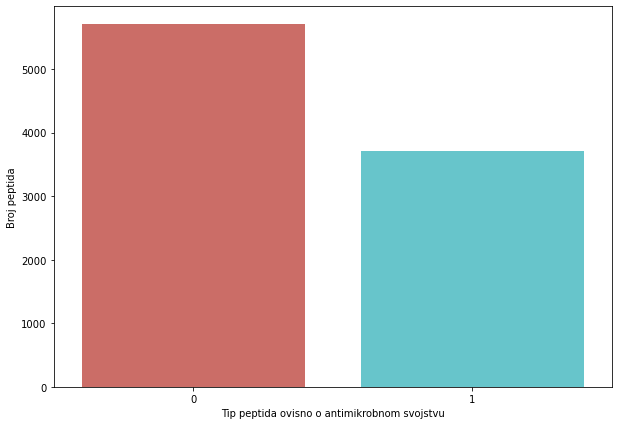

In [3]:
rcParams['figure.figsize'] =  10,7
sns.countplot(x='label', data=df, palette='hls')
plt.xlabel('Tip peptida ovisno o antimikrobnom svojstvu')
plt.ylabel('Broj peptida')
plt.show()

In [4]:
# Učitavanje podataka i podjela na skupove za trening i testiranje
(x_train_peptides, x_test_peptides, y_train_peptide_types, y_test_peptide_types) = train_test_split(peptides, peptides_type, test_size=0.2, random_state=42)
x_train_onehotencoded = one_hot_encode_list(x_train_peptides)
x_train_onehotencoded = x_train_onehotencoded.reshape((7527, 50, 21))
x_test_onehotencoded = one_hot_encode_list(x_test_peptides)
x_test_onehotencoded = x_test_onehotencoded.reshape((1882, 50, 21))
print(x_train_onehotencoded.shape, x_test_onehotencoded.shape)

(7527, 50, 21) (1882, 50, 21)


In [5]:
onehotencode_shape = x_train_onehotencoded.shape[1:]
print(onehotencode_shape)
print(x_train_peptides.shape)

(50, 21)
(7527,)


In [6]:
# Funkcija za crtanje latentnog prostora iz enkodiranih podataka (trening i testni skup)
def plot_input_data(encoder, x_data, y_data, title):
    z_input, _ = encoder.predict(x_data)
    unique_labels = np.unique(y_data)
    label_colors = ['blue', 'orange']
    label_names = ['NON AMP', 'AMP']
    
    for label in unique_labels:
        indices = np.where(y_data == label)[0]
        plt.scatter(z_input[indices, 0], z_input[indices, 1], c=label_colors[label], label=label_names[label])

    plt.xlabel("Latentna dimenzija 1")
    plt.ylabel("Latentna dimenzija 2")
    plt.title(title)
    plt.legend()
    plt.show()

In [7]:
# Funkcija za crtanje latentnog prostora iz enkodiranih rekonstruiranih podataka (trening i testni skup)
def plot_reconstructed_data(encoder, decoder, x_data, y_data, title):
    z_input, _ = encoder.predict(x_data)
    reconstructed_input = decoder.predict(z_input)
    reconstruced_z_input, _ = encoder.predict(reconstructed_input)
    
    unique_labels = np.unique(y_data)
    label_colors = ['blue', 'orange']
    label_names = ['NON AMP', 'AMP']
    
    for label in unique_labels:
        indices = np.where(y_data == label)[0]
        plt.scatter(reconstruced_z_input[indices, 0], reconstruced_z_input[indices, 1], 
                    c=label_colors[label], label=label_names[label])

    plt.xlabel("Latentna dimenzija 1")
    plt.ylabel("Latentna dimenzija 2")
    plt.title(title)
    plt.legend()
    plt.show()
    
title_enc_training_data = "Podaci za trening enkodirani u latentni prostor"
title_enc_test_data = "Podaci za test enkodirani u latentni prostor"
title_recon_enc_training_data = "Rekonstruirani trening podaci enkodirani u latentni prostor"
title_recon_enc_test_data ="Rekonstruirani testni podaci enkodirani u latentni prostor"

In [8]:
# Arhitektura enkodera
def create_seq_encoder_model(input_shape, latent_dim=2, lstm_cells=64):
    inp = Input(shape=input_shape, name="input_1_enc")
    x = LSTM(lstm_cells, unroll=True, name="lstm_enc")(inp)
    z = Dense(32, activation='relu', name="output_dense_enc")(x)
    z_mean = Dense(latent_dim)(z)
    z_log_sigma = Dense(latent_dim)(z)
    
    encoder_model = Model(inputs=inp, outputs=[z_mean, z_log_sigma], name="encoder")
    return encoder_model

In [9]:
# Arhitektura dekodera
def create_seq_decoder_model(input_shape, latent_dim=2, lstm_cells=64):
    model_input = Input(shape=(latent_dim,), name="input_1_dec")
    x = RepeatVector(input_shape[0])(model_input)
    x = LSTM(lstm_cells, unroll=True, name="lstm_dec", return_sequences=True)(x)
#     out = TimeDistributed(Dense(input_shape[1], activation='linear'))(x)
#    softmax
    out = TimeDistributed(Dense(input_shape[1]))(x)
    last_dense = Activation(softmax_beta)(out)
    
    decoder_model = Model(inputs=model_input, outputs=last_dense, name="decoder")
    return decoder_model

In [10]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder     
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def set_seed(self, seed):
        self.random_seed = seed
        tf.random.set_seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)
        np.random.seed(seed)
        random.seed(seed)
    
    # Uzorkovanje iz latentnog prostora
    def sampling(self, args):
        z_mean, z_log_sigma = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_sigma) * epsilon

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_sigma = self.encoder(data)
            z = Lambda(self.sampling)([z_mean, z_log_sigma])
            reconstruction = self.decoder(z)
            
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_sigma - tf.square(z_mean) - tf.exp(z_log_sigma), axis=1)
            )
#             mean_squared_error, binary_crossentropy
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=1
                )
            )
            
            total_loss = reconstruction_loss + kl_loss
        
        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        x = data[0]
        z_mean, z_log_sigma = self.encoder(data)
        z = Lambda(self.sampling)([z_mean, z_log_sigma])
        reconstructed_x = self.decoder(z)
        kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_sigma - tf.square(z_mean) - tf.exp(z_log_sigma), axis=1)
            )

        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.binary_crossentropy(data, reconstructed_x), axis=1
            )
        )
        total_loss = reconstruction_loss + kl_loss
        self.compiled_metrics.update_state(x, reconstructed_x)

        results = {m.name: m.result() for m in self.metrics}
        results["reconstruction_loss"] = reconstruction_loss
        results["kl_loss"] = kl_loss
        results["total_loss"] = total_loss
        return results

In [11]:
# DEFINIRANJE POVRATNIH POZIVA ZA PRAĆENJE GUBITAKA I LEARNING RATES-a TIJEKOM TRENINGA
learning_rates = []

class LearningRateScheduler(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
        learning_rates.append(lr)
        
class LossHistoryCallback(Callback):
    def on_train_begin(self, logs=None):
        self.losses = []

    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs['loss'])
        self.losses.append(logs['reconstruction_loss'])
        self.losses.append(logs['kl_loss'])

In [12]:
# Pokušaj skaliranja koeficijenta s kojim se mnozi kl_loss (kako bi uštimali model)
class LossCallback(tf.keras.callbacks.Callback):
    def __init__(self, model):
        super(LossCallback, self).__init__()
        model.beta_x = tf.Variable(1.0, trainable=False, name='weight1', dtype=tf.float32)

#     def on_epoch_begin(self, epoch, logs=None):
# #         tf.keras.backend.set_value(self.model.beta_x, tf.constant(0.5) * epoch)
#         kl_scaling_schedule = [2500, 3000, 3500, 2000, 1500, 1000, 500, 1.7, 1.7, 1.7, 1.7, 1.7]
#         if epoch < len(kl_scaling_schedule):
#             scalling_factor = kl_scaling_schedule[epoch]
#         tf.keras.backend.set_value(self.model.beta_x, scalling_factor)

#     def on_epoch_end(self, epoch, logs=None):
#         logs = logs or {}
#         logs['beta_x'] = tf.keras.backend.get_value(self.model.beta_x)
#         print(logs['beta_x'])

In [13]:
encoder = create_seq_encoder_model(input_shape=onehotencode_shape)
encoder.summary()
decoder = create_seq_decoder_model(input_shape=onehotencode_shape, latent_dim=2)
decoder.summary()
vae = VAE(encoder, decoder)
vae.set_seed(31)

callback = LossCallback(vae)
lr_scheduler = LearningRateScheduler()
loss_callback = LossHistoryCallback()
vae.compile(loss=None, optimizer=keras.optimizers.Adam())

# tensorboard --logdir=C:\Users\StarLord\Documents\Diplomski\VAEs\tmp\onehot-vae\
# TensorBoard(log_dir='C:\\Users\\StarLord\\Documents\\Diplomski\\VAEs\\tmp\\onehot-vae')

# x_train_onehotencoded, x_test_onehotencoded, y_train_peptide_types, y_test_peptide_types
es = EarlyStopping(patience=5, verbose=1, min_delta=0.01, monitor='loss', mode='auto', restore_best_weights=True)
trained_model = vae.fit(x_train_onehotencoded, batch_size=128, epochs=100, 
        validation_data=(x_test_onehotencoded, None), 
        shuffle=False,
        callbacks=[es, callback, lr_scheduler, loss_callback])

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1_enc (InputLayer)       [(None, 50, 21)]     0           []                               
                                                                                                  
 lstm_enc (LSTM)                (None, 64)           22016       ['input_1_enc[0][0]']            
                                                                                                  
 output_dense_enc (Dense)       (None, 32)           2080        ['lstm_enc[0][0]']               
                                                                                                  
 dense (Dense)                  (None, 2)            66          ['output_dense_enc[0][0]']       
                                                                                            

236/236 [==============================] - 3s 7ms/step


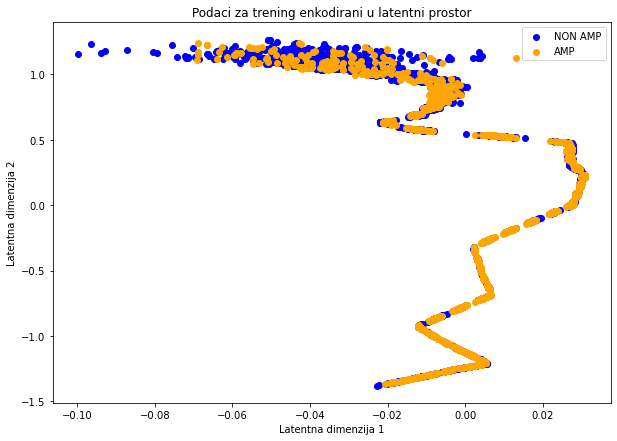

236/236 [==============================] - 1s 6ms/step


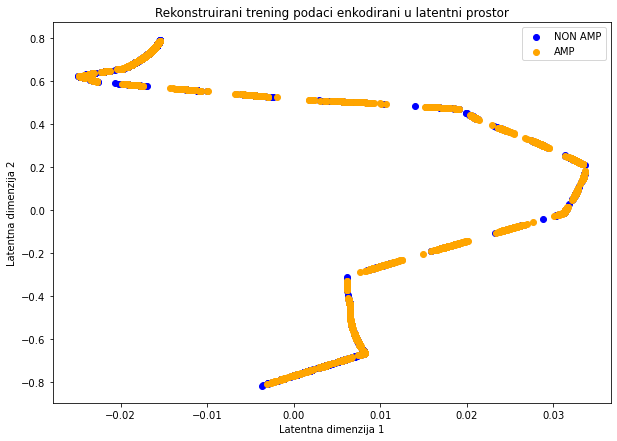

59/59 [==============================] - 0s 7ms/step


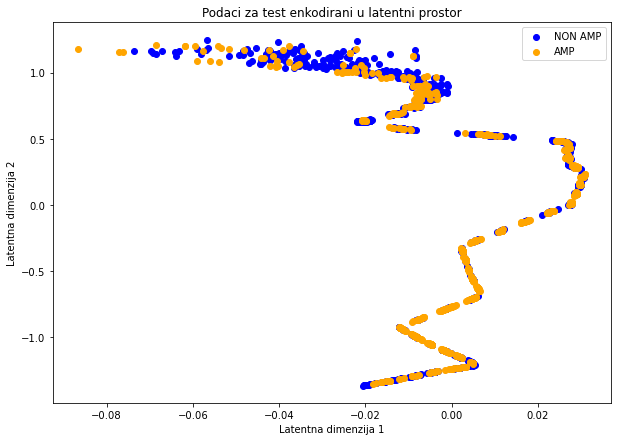

59/59 [==============================] - 1s 8ms/step


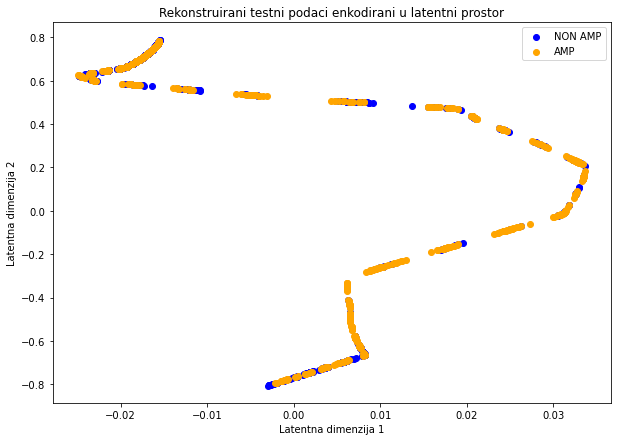

In [14]:
# x_train_onehotencoded, x_test_onehotencoded, y_train_peptide_types, y_test_peptide_types
# train data in latent space
plot_input_data(vae.encoder, x_train_onehotencoded, y_train_peptide_types, title_enc_training_data)
# reconstructed train data in latent space
plot_reconstructed_data(vae.encoder, vae.decoder, x_train_onehotencoded, y_train_peptide_types, title_recon_enc_training_data)
# test data in latent space
plot_input_data(vae.encoder, x_test_onehotencoded, y_test_peptide_types, title_enc_test_data)
# reconstructed test data in latent space
plot_reconstructed_data(vae.encoder, vae.decoder, x_test_onehotencoded, y_test_peptide_types, title_recon_enc_test_data)

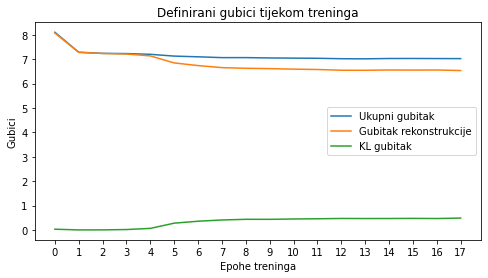

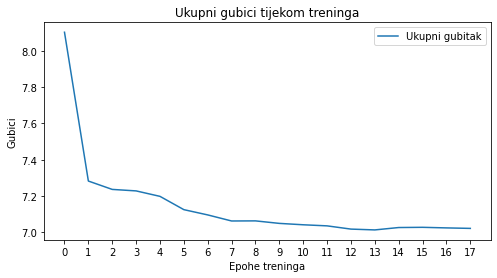

In [15]:
# Vizualizacija gubitaka
plt.figure(figsize=(8, 4))
plt.plot(trained_model.history['loss'], label='Ukupni gubitak')
plt.plot(trained_model.history['reconstruction_loss'], label='Gubitak rekonstrukcije')
plt.plot(trained_model.history['kl_loss'], label='KL gubitak')
plt.xlabel('Epohe treninga')
plt.ylabel('Gubici')
plt.title('Definirani gubici tijekom treninga')
plt.legend()
plt.xticks(range(len(trained_model.history['loss'])))

plt.figure(figsize=(8, 4))
plt.plot(trained_model.history['loss'], label='Ukupni gubitak')
plt.xlabel('Epohe treninga')
plt.ylabel('Gubici')
plt.title('Ukupni gubici tijekom treninga')
plt.legend()
plt.xticks(range(len(trained_model.history['loss'])))

plt.show()

In [16]:
np.set_printoptions(threshold=1000)

# Peptidi dobiveni nakon dekodiranja trening skupa
enc_pred, _ = vae.encoder.predict(x_train_onehotencoded)
decoded_data_train = vae.decoder.predict(enc_pred)
    
decoded_seq = []
decoded_sequences_train = []
for sequence_array in decoded_data_train:
    for seq in sequence_array:
        closest_to_1_index = np.argmax(np.abs(seq))
        binary_sequence = np.zeros_like(seq)
        binary_sequence[closest_to_1_index] = 1
        decoded_seq.append(binary_sequence)
        converted = np.array(decoded_seq)       
    decoded_sequences_train.append(converted)    
    decoded_seq = []


decoded_peptides_train = one_hot_decode_list(decoded_sequences_train)
print(decoded_peptides_train[:5])
print(len(decoded_peptides_train))


# Peptidi dobiveni nakon dekodiranja test skupa
enc_pred, _ = vae.encoder.predict(x_test_onehotencoded)
decoded_data_test = vae.decoder.predict(enc_pred)
    
decoded_seq = []
decoded_sequences_test = []
for sequence_array in decoded_data_test:
    for seq in sequence_array:
        closest_to_1_index = np.argmax(np.abs(seq))
        binary_sequence = np.zeros_like(seq)
        binary_sequence[closest_to_1_index] = 1
        decoded_seq.append(binary_sequence)
        converted = np.array(decoded_seq)       
    decoded_sequences_test.append(converted)    
    decoded_seq = []


decoded_peptides_test = one_hot_decode_list(decoded_sequences_test)
decoded_peptides_train_stripped = [x.strip() for x in decoded_peptides_train]
decoded_peptides_test_stripped = [x.strip() for x in decoded_peptides_test]

236/236 [==============================] - 2s 8ms/step
['KKKKKKKLLLLLLLLLLLLGGGGGRRRRRRR                   ', 'KKKKKKKKLLLLLLLLLLLGGRRRRRRRRRRR                  ', 'LLLLLLLL                                          ', 'LLLLLLLLLLLLLL                                    ', 'KLLLLLLLLLLLLLLLLLL                               ']
7527
59/59 [==============================] - 0s 8ms/step


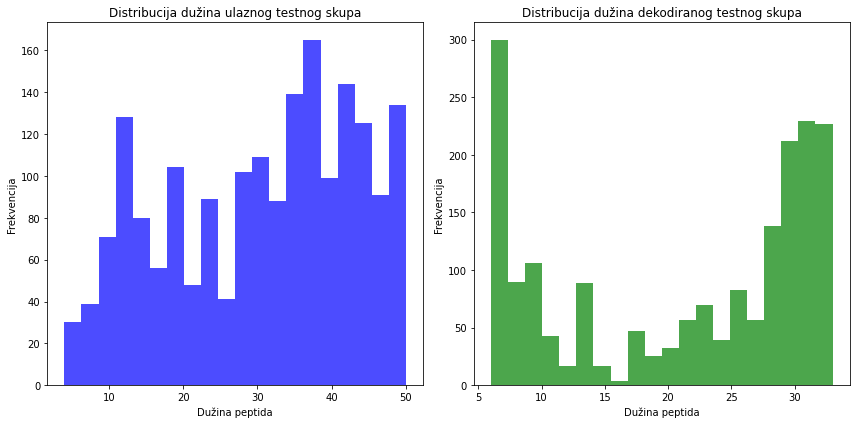

Srednja vrijednost duzine (Ulazni): 30.48
Srednja vrijednost duzine (Dobiveni): 21.12


In [17]:
# ANALIZA DUZINE PEPTIDA (ULAZNIH I DEKODIRANIH (IZLAZNIH))
# Usporedba duljina dobivenih peptida i ulazniha za TESTNI skup
original_lengths = [len(seq) for seq in x_test_peptides]
generated_lengths = [len(seq) for seq in decoded_peptides_test_stripped]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(original_lengths, bins=20, color='blue', alpha=0.7)
plt.xlabel('Dužina peptida')
plt.ylabel('Frekvencija')
plt.title('Distribucija dužina ulaznog testnog skupa')

plt.subplot(1, 2, 2)
plt.hist(generated_lengths, bins=20, color='green', alpha=0.7)
plt.xlabel('Dužina peptida')
plt.ylabel('Frekvencija')
plt.title('Distribucija dužina dekodiranog testnog skupa')
plt.tight_layout()
plt.show()

original_mean_length = np.mean(original_lengths)
generated_mean_length = np.mean(generated_lengths)

print(f"Srednja vrijednost duzine (Ulazni): {original_mean_length:.2f}")
print(f"Srednja vrijednost duzine (Dobiveni): {generated_mean_length:.2f}")

Kraci: 1852 Dulji: 16 Jednaki: 14
Srednja vrijednost razlike dužine - dobivenih peptida duljih od ulaznih (test skup):  1.4375
Srednja vrijednost razlike dužine - dobivenih peptida kracih od ulaznih (test skup):  9.522138228941685


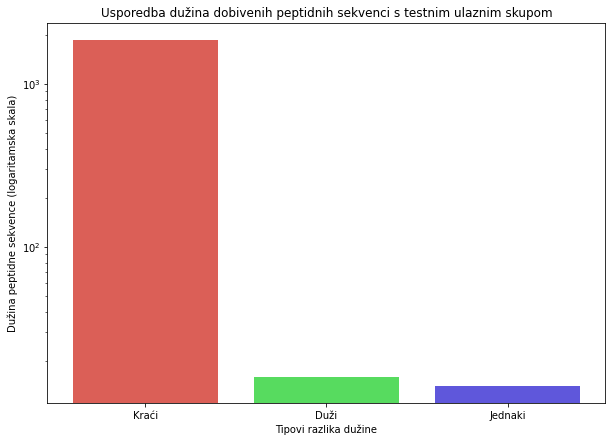

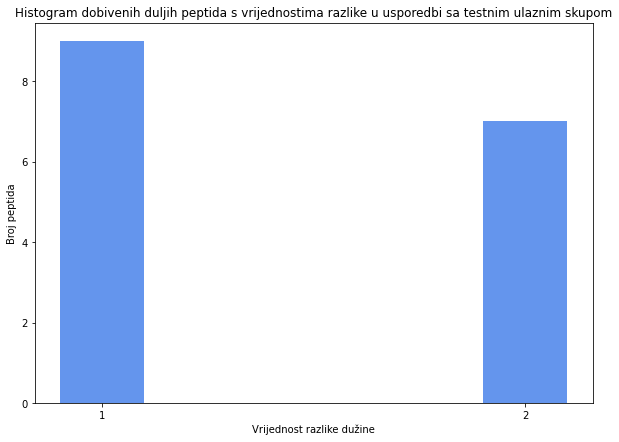

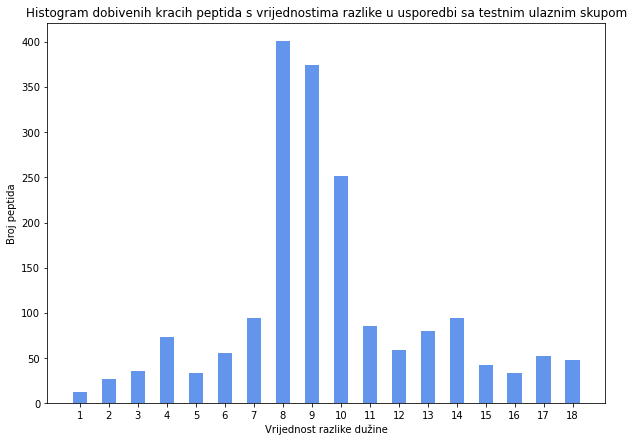

In [18]:
test_dulji = 0
test_kraci = 0
test_jednaki = 0

test_razlika_duljih = {}
test_razlika_kracih = {}
test_razlika_jednakih = {}

avg_dulji = 0
avg_kraci = 0

for i, peptide in enumerate(x_test_peptides):
#   Dulji  
    if len(decoded_peptides_test[i].strip()) > len(peptide):
        test_dulji += 1
        diff_dulji = len(decoded_peptides_test[i].strip()) - len(peptide)
        avg_dulji += diff_dulji
        if diff_dulji in test_razlika_duljih:
            test_razlika_duljih[diff_dulji] += 1
        else:
            test_razlika_duljih[diff_dulji] = 1 
#   Kraci          
    elif len(decoded_peptides_test[i].strip()) < len(peptide):
        test_kraci += 1
        diff_kraci = len(peptide) - len(decoded_peptides_test[i].strip())
        avg_kraci += diff_kraci
        
        if diff_kraci in test_razlika_kracih:
            test_razlika_kracih[diff_kraci] += 1
        else:
            test_razlika_kracih[diff_kraci] = 1
#   Jednaki         
    else :
        test_jednaki += 1
        if len(peptide) in test_razlika_jednakih:
            test_razlika_jednakih[len(peptide)] += 1
        else:
            test_razlika_jednakih[len(peptide)] = 1

print("Kraci:",test_kraci, "Dulji:", test_dulji, "Jednaki:", test_jednaki)
if test_dulji:
    print("Srednja vrijednost razlike dužine - dobivenih peptida duljih od ulaznih (test skup): ", avg_dulji/test_dulji)
    
if test_kraci:
    print("Srednja vrijednost razlike dužine - dobivenih peptida kracih od ulaznih (test skup): ", avg_kraci/test_kraci)

# Podaci za plot - razlike tipova duzine
categories = ['Kraći', 'Duži', 'Jednaki']
counts = [test_kraci, test_dulji, test_jednaki]

custom_palette = sns.color_palette('hls', n_colors=3)
blue, orange, green = custom_palette

plt.bar(categories, counts, color=[blue, orange, green])
plt.xlabel('Tipovi razlika dužine')
plt.ylabel('Dužina peptidne sekvence (logaritamska skala)')
plt.yscale('log')
plt.title('Usporedba dužina dobivenih peptidnih sekvenci s testnim ulaznim skupom')
plt.show()
 
# Histogram razlika duzina - duljih peptida
razlika_duzine = list(test_razlika_duljih.keys())
vrijednosti_izbrojenih = list(test_razlika_duljih.values())
plt.bar(razlika_duzine, vrijednosti_izbrojenih, width=0.2, color='cornflowerblue')
plt.xlabel('Vrijednost razlike dužine')
plt.ylabel('Broj peptida')
plt.title('Histogram dobivenih duljih peptida s vrijednostima razlike u usporedbi sa testnim ulaznim skupom')
plt.xticks(np.arange(min(razlika_duzine), max(razlika_duzine) + 1, 1))
plt.show()

# Histogram razlika duzina - kracih peptida
razlika_duzine = list(test_razlika_kracih.keys())
vrijednosti_izbrojenih = list(test_razlika_kracih.values())
plt.bar(razlika_duzine, vrijednosti_izbrojenih, width=0.5, color='cornflowerblue')
plt.xlabel('Vrijednost razlike dužine')
plt.ylabel('Broj peptida')
plt.title('Histogram dobivenih kracih peptida s vrijednostima razlike u usporedbi sa testnim ulaznim skupom')
plt.xticks(np.arange(min(razlika_duzine), max(razlika_duzine) + 1, 1))
plt.show()

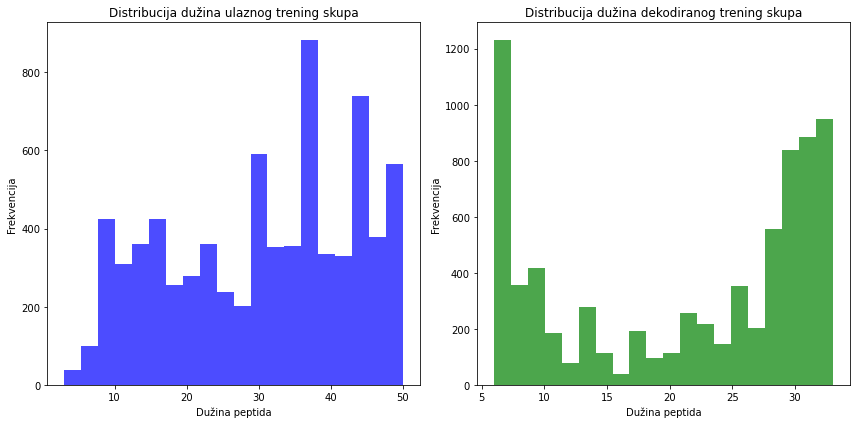

Srednja vrijednost duzine (Ulazni): 30.47
Srednja vrijednost duzine (Dobiveni): 21.06


In [19]:
# Usporedba duljina dobivenih peptida i ulazniha za TRENING skup
original_lengths = [len(seq) for seq in x_train_peptides]
generated_lengths = [len(seq) for seq in decoded_peptides_train_stripped]

# Create histograms for original and generated sequences
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(original_lengths, bins=20, color='blue', alpha=0.7)
plt.xlabel('Dužina peptida')
plt.ylabel('Frekvencija')
plt.title('Distribucija dužina ulaznog trening skupa')

plt.subplot(1, 2, 2)
plt.hist(generated_lengths, bins=20, color='green', alpha=0.7)
plt.xlabel('Dužina peptida')
plt.ylabel('Frekvencija')
plt.title('Distribucija dužina dekodiranog trening skupa')
plt.tight_layout()
plt.show()

original_mean_length = np.mean(original_lengths)
generated_mean_length = np.mean(generated_lengths)

print(f"Srednja vrijednost duzine (Ulazni): {original_mean_length:.2f}")
print(f"Srednja vrijednost duzine (Dobiveni): {generated_mean_length:.2f}")

Kraci: 7453 Dulji: 38 Jednaki: 36
Srednja vrijednost razlike dužine - dobivenih peptida duljih od ulaznih (trening skup):  1.394736842105263
Srednja vrijednost razlike dužine - dobivenih peptida kraćih od ulaznih (trening skup):  9.503958137662686


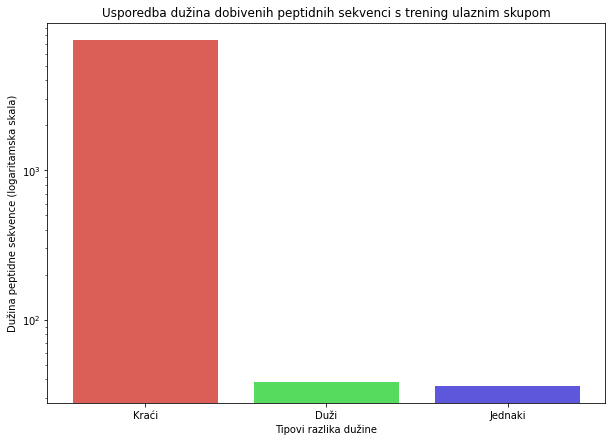

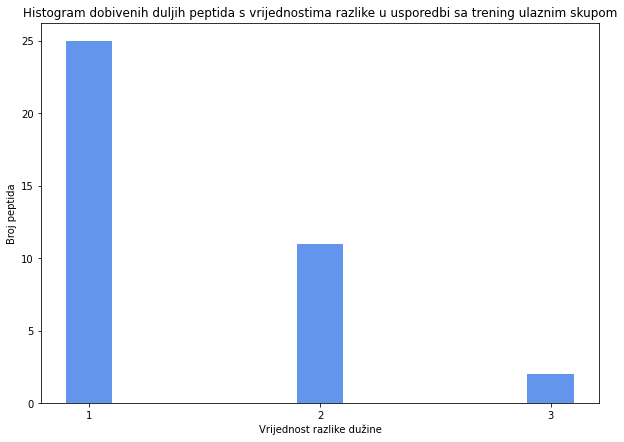

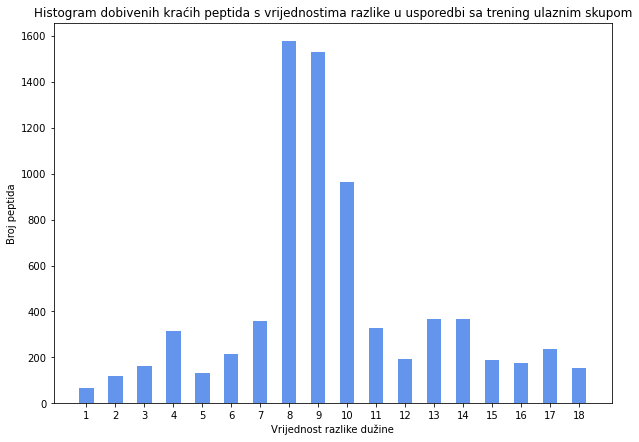

In [20]:
train_dulji = 0
train_kraci = 0
train_jednaki = 0

train_razlika_duljih = {}
train_razlika_kracih = {}
train_razlika_jednakih = {}

avg_dulji = 0
avg_kraci = 0

for i, peptide in enumerate(x_train_peptides):
    if len(decoded_peptides_train[i].strip()) > len(peptide):
        train_dulji += 1
        diff_dulji = len(decoded_peptides_train[i].strip()) - len(peptide)
        avg_dulji += diff_dulji
        if diff_dulji in train_razlika_duljih:
            train_razlika_duljih[diff_dulji] += 1
        else:
            train_razlika_duljih[diff_dulji] = 1 
            
    elif len(decoded_peptides_train[i].strip()) < len(peptide):
        train_kraci += 1
        diff_kraci = len(peptide) - len(decoded_peptides_train[i].strip())
        avg_kraci += diff_kraci
        
        if diff_kraci in train_razlika_kracih:
            train_razlika_kracih[diff_kraci] += 1
        else:
            train_razlika_kracih[diff_kraci] = 1
            
    else :
        train_jednaki += 1
        if len(peptide) in train_razlika_jednakih:
            train_razlika_jednakih[len(peptide)] += 1
        else:
            train_razlika_jednakih[len(peptide)] = 1

print("Kraci:",train_kraci, "Dulji:", train_dulji, "Jednaki:", train_jednaki)
if train_dulji:
    print("Srednja vrijednost razlike dužine - dobivenih peptida duljih od ulaznih (trening skup): ", avg_dulji/train_dulji)
    
if train_kraci:
    print("Srednja vrijednost razlike dužine - dobivenih peptida kraćih od ulaznih (trening skup): ", avg_kraci/train_kraci)

# Podaci za plot - razlike tipova duzine
categories = ['Kraći', 'Duži', 'Jednaki']
counts = [train_kraci, train_dulji, train_jednaki]

custom_palette = sns.color_palette('hls', n_colors=3)
blue, orange, green = custom_palette

plt.bar(categories, counts, color=[blue, orange, green])
plt.xlabel('Tipovi razlika dužine')
plt.ylabel('Dužina peptidne sekvence (logaritamska skala)')
plt.yscale('log')
plt.title('Usporedba dužina dobivenih peptidnih sekvenci s trening ulaznim skupom')
plt.show()
 
# Histogram razlika duzina - duljih peptida
razlika_duzine = list(train_razlika_duljih.keys())
vrijednosti_izbrojenih = list(train_razlika_duljih.values())
plt.bar(razlika_duzine, vrijednosti_izbrojenih, width=0.2, color='cornflowerblue')
plt.xlabel('Vrijednost razlike dužine')
plt.ylabel('Broj peptida')
plt.title('Histogram dobivenih duljih peptida s vrijednostima razlike u usporedbi sa trening ulaznim skupom')
plt.xticks(np.arange(min(razlika_duzine), max(razlika_duzine) + 1, 1))
plt.show()

# Histogram razlika duzina - kracih peptida
razlika_duzine = list(train_razlika_kracih.keys())
vrijednosti_izbrojenih = list(train_razlika_kracih.values())
plt.bar(razlika_duzine, vrijednosti_izbrojenih, width=0.5, color='cornflowerblue')
plt.xlabel('Vrijednost razlike dužine')
plt.ylabel('Broj peptida')
plt.title('Histogram dobivenih kraćih peptida s vrijednostima razlike u usporedbi sa trening ulaznim skupom')
plt.xticks(np.arange(min(razlika_duzine), max(razlika_duzine) + 1, 1))
plt.show()

In [21]:
# ANALIZA SLIČNOSTI PEPTIDA PREMA SEKVENCI
from Bio import pairwise2
from Bio.Seq import Seq

# Broj izmedu 0 i 1, sto je blize 1 to su slicniji
def calculate_sequence_similarity(seq1, seq2):
  
    seq1 = Seq(seq1)
    seq2 = Seq(seq2)

    alignments = pairwise2.align.globalxx(seq1, seq2)

    best_alignment = alignments[0]
    seq1_aligned, seq2_aligned, score, begin, end = best_alignment

    similarity = (score / max(len(seq1), len(seq2)))

    return similarity

C:\Users\StarLord\anaconda3\lib\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


Srednja vrijednosti slicnosti dobivenih peptida sa ulaznim testnim 0.14501062883190774


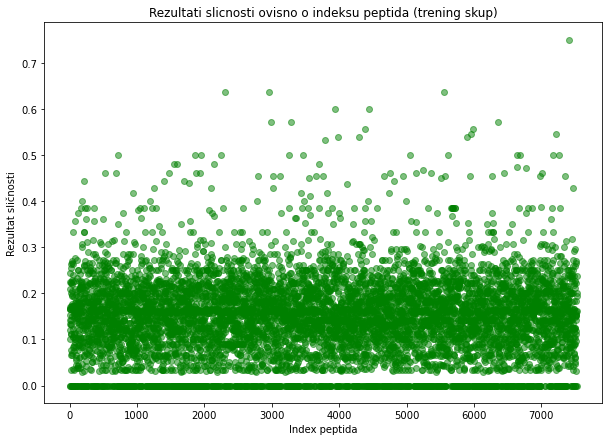

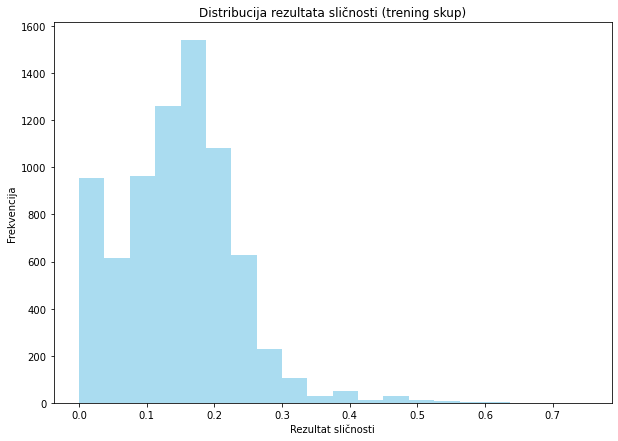

In [22]:
# Usporedba slicnosti dobivenih dekodiranih peptida sa ulaznima
# Trening set usporedba
decoded_peptides_train_stripped = [x.strip() for x in decoded_peptides_train]
rezultati_slicnosti_train = []

for i, peptide in enumerate(x_train_peptides):
    slicnost = calculate_sequence_similarity(decoded_peptides_train_stripped[i], peptide)
    rezultati_slicnosti_train.append(slicnost)

sum_slicnosti_train = sum(rezultati_slicnosti_train)
avg_slicnosti_train = sum_slicnosti_train/len(x_train_peptides)

print("Srednja vrijednosti slicnosti dobivenih peptida sa ulaznim testnim", avg_slicnosti_train)

plt.scatter(range(len(rezultati_slicnosti_train)), rezultati_slicnosti_train, color='green', alpha=0.5)
plt.xlabel('Index peptida')
plt.ylabel('Rezultat sličnosti')
plt.title('Rezultati slicnosti ovisno o indeksu peptida (trening skup)')
plt.show()

plt.hist(rezultati_slicnosti_train, bins=20, color='skyblue', alpha=0.7)
plt.xlabel('Rezultat sličnosti')
plt.ylabel('Frekvencija')
plt.title('Distribucija rezultata sličnosti (trening skup)')
plt.show()

Srednja vrijednosti slicnosti dobivenih peptida sa ulaznim testnim 0.03508606517786262


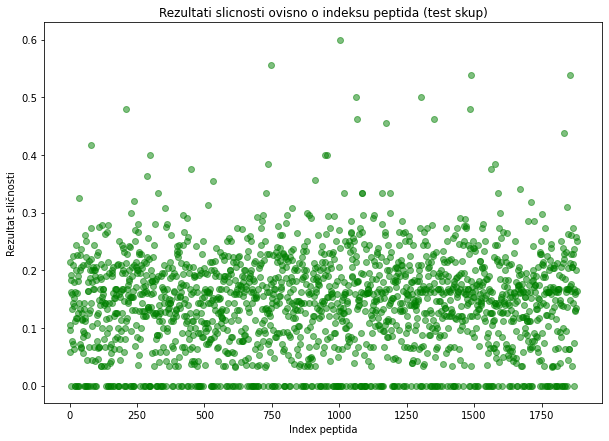

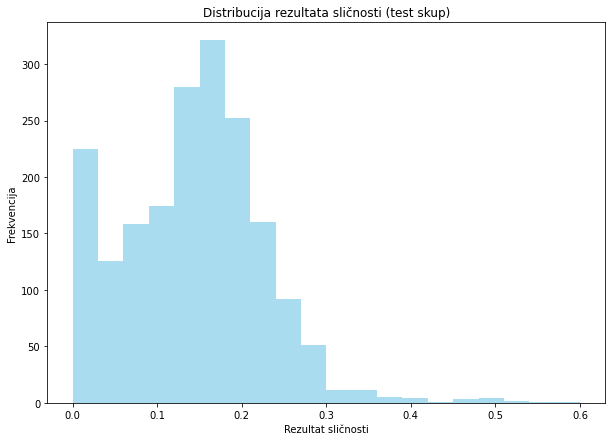

In [23]:
# Test set usporedba
decoded_peptides_test_stripped = [x.strip() for x in decoded_peptides_test]
rezultati_slicnosti_test = []

for i, peptide in enumerate(x_test_peptides):
    slicnost = calculate_sequence_similarity(decoded_peptides_test_stripped[i], peptide)
    rezultati_slicnosti_test.append(slicnost)

sum_slicnosti_test = sum(rezultati_slicnosti_test)
avg_slicnosti_test = sum_slicnosti_test/len(x_train_peptides)

print("Srednja vrijednosti slicnosti dobivenih peptida sa ulaznim testnim", avg_slicnosti_test)

plt.scatter(range(len(rezultati_slicnosti_test)), rezultati_slicnosti_test, color='green', alpha=0.5)
plt.xlabel('Index peptida')
plt.ylabel('Rezultat sličnosti')
plt.title('Rezultati slicnosti ovisno o indeksu peptida (test skup)')
plt.show()

plt.hist(rezultati_slicnosti_test, bins=20, color='skyblue', alpha=0.7)
plt.xlabel('Rezultat sličnosti')
plt.ylabel('Frekvencija')
plt.title('Distribucija rezultata sličnosti (test skup)')
plt.show()

In [24]:
# Validacija modela predikcijom antimikrobnog svojstva nad novim dekodiranim peptidima
feature_set = ['Hydrophobicity_Aboderin', 'tScales_T3', 'Hydrophobicity_Fauchere', 'stScales_ST4', 'VHSE_VHSE3', 'BLOSUM_BLOSUM5', 'Hydrophobicity_Ponnuswamy', 'crucianiProperties_PP1', 'Hydrophobicity_Welling', 'Hydrophobicity_Chothia']
encoder = SequentialPropertiesEncoder(scaler=MinMaxScaler(feature_range=(-1, 1)), stop_signal=True, max_seq_len=max_peptide_len-1, selected_properties=feature_set)

encoded_sequences_train = encoder.encode(decoded_peptides_train_stripped)
encoded_sequences_test = encoder.encode(decoded_peptides_test_stripped)

model = models.create_seq_model(input_shape=encoded_sequences_train.shape[1:], conv1_filters=64, conv2_filters=64, conv_kernel_size=4, num_cells=128, dropout=0.1)

loaded_model = tf.keras.models.load_model("seqprops_therapeutic/pretrained_models/amp")
model.set_weights(loaded_model.get_weights())

predicted_labels_train = []
predicted_labels_test = []

# Predikcija antimikrobnog svojstva nad trening skupom
y_pred = model.predict(encoded_sequences_train, verbose=0)
for idx in range(len(y_pred)):
    predicted_probability = y_pred[idx][0]
    if predicted_probability > 0.5:
        predicted_labels_train.append(1)
    else:
        predicted_labels_train.append(0)
    
# Predikcija antimikrobnog svojstva nad testnim skupom
y_pred = model.predict(encoded_sequences_test, verbose=0)
for idx in range(len(y_pred)):
    predicted_probability = y_pred[idx][0]
    if predicted_probability > 0.5:
        predicted_labels_test.append(1)
    else:
        predicted_labels_test.append(0)

In [25]:
# Testiranje točnosti sa izvornim ulaznim oznakama 

# Testiranje predikcija nad trening skupom
predicted_labels_train = np.array(predicted_labels_train)
comparison = predicted_labels_train == y_train_peptide_types
matching_count = np.sum(comparison)

print("Ukupan broj trening skupa peptida:", len(predicted_labels_train))
print("Točna predikcija nad:", matching_count)
print("Kriva predikcija nad:", len(predicted_labels_train)-matching_count)
print(matching_count/len(predicted_labels_train) * 100)

# matched = []
# missed = []

# for index, value in enumerate(predicted_labels_train):
#     if value == y_train_peptide_types[index]:
#         matched.append(1)
#     else:
#         missed.append(1)

# print(len(matched))
# print(len(missed))

# Matrica zabune
conf_matrix = confusion_matrix(y_train_peptide_types, predicted_labels_train)
print("Matrica konfuzije (antimikrobno svojstvo - izvorni trening set/dekodirani trening set):")
print(conf_matrix)

# conf_matrix[0, 0] represents the number of samples with the original value 0 (negative class) that were correctly classified as 0 (true negatives).
# conf_matrix[0, 1] represents the number of samples with the original value 0 that were incorrectly classified as 1 (false positives).
# conf_matrix[1, 0] represents the number of samples with the original value 1 (positive class) that were incorrectly classified as 0 (false negatives).
# conf_matrix[1, 1] represents the number of samples with the original value 1 that were correctly classified as 1 (true positives)

Ukupan broj trening skupa peptida: 7527
Točna predikcija nad: 4065
Kriva predikcija nad: 3462
54.00557991231566
Matrica konfuzije (antimikrobno svojstvo - izvorni trening set/dekodirani trening set):
[[1648 2919]
 [ 543 2417]]


In [26]:
# Testiranje predikcija nad testnim skupom
predicted_labels_test = np.array(predicted_labels_test)
comparison = predicted_labels_test == y_test_peptide_types
matching_count = np.sum(comparison)

print("Ukupan broj testnog skupa peptida:", len(predicted_labels_test))
print("Točna predikcija nad:", matching_count)
print("Kriva predikcija nad:", len(predicted_labels_test)-matching_count)

# Matrica zabune
conf_matrix = confusion_matrix(y_test_peptide_types, predicted_labels_test)
print("Matrica konfuzije (antimikrobno svojstvo - izvorni testni set/dekodirani testni set):")
print(conf_matrix)

Ukupan broj testnog skupa peptida: 1882
Točna predikcija nad: 1025
Kriva predikcija nad: 857
Matrica konfuzije (antimikrobno svojstvo - izvorni testni set/dekodirani testni set):
[[400 734]
 [123 625]]
